# Data processing of continuos glucose measurements


In [0]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime
import pytz
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from multiprocessing import  Pool, cpu_count
from functools import partial

## Load dataset

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
root = '/content/drive/My Drive/Colab Notebooks/sugar_level_prediction/data/'
outdir = os.path.join(root, 'processed', datetime.now().strftime("%Y-%m-%d"))
os.makedirs(outdir, exist_ok=True)

files = [f for f in os.listdir(root) if os.path.isfile(os.path.join(root, f))]
print(files)

['patient4_measurements_5minutes_sample.csv', 'patient3_measurements_5minutes_sample.csv', 'patient1_measurements_15minutes_sample.csv', 'patient2_measurements_15minutes_sample.csv', 'patient5_measurements_5minutes_sample.csv', 'patient6_measurements_15minutes_sample.csv', 'patient0_measurements_15minutes_sample.csv', 'patient7_measurements_5minutes_sample.csv', 'patient8_measurements_5minutes_sample.csv']


### Choose features and format timestamps



In [0]:
def datetime_parser(series):
    possible_formats = ['%Y/%m/%d %H:%M:%S', 
                        '%Y/%m/%d %H:%M',
                        '%m-%d-%Y %I:%M %p', 
                        '%d.%m.%Y %H:%M',
                        '%Y-%m-%dT%H:%M:%S.%f%z',
                        '%Y-%m-%dT%H:%M:%S',
                        '%d/%m/%Y %H:%M'
                        ]

    raw_string_date = series.values[0]
    parsed_date = None
    for date_format in possible_formats:
      try:
          parsed_date = datetime.strptime(raw_string_date, date_format) # try to get the date
          break # if correct format, don't test any other formats
      except ValueError:
          pass # keep iterating

    if parsed_date:
      if '%z' not in date_format:
        out = pd.to_datetime(series, format=date_format, utc=True)
      else:
        out = pd.to_datetime(series, format=date_format)
    else:
      print('Warning: date format not obtained, we are going to allow pandas to infer it', raw_string_date)
      out = pd.to_datetime(series, infer_datetime_format=True)
    out = out.apply(lambda x: x.replace(microsecond=0).replace(tzinfo=None))
    
    return out

In [34]:
final_columns = ['id', 'timestamp', 'aut_record']

list_df = []
sampling ={}
for filename in files:
  i = int(filename[7:8])
  data_file = os.path.join(root, filename)
  # Data can be sampled in 5 or 15 minutes. We will sample the timeseries every 15 minutes
  sampling_rate = int(filename[22:23])
  sampling[i] = 3 if sampling_rate == 5 else 1

  dfs = pd.read_csv(data_file, sep=',', header=None, encoding='utf-8', 
                    names=final_columns[1:])
  dfs['id'] = i
  
  # format records and drop nans
  dfs = dfs.dropna(inplace=False, subset=['aut_record'])
  dfs.aut_record = dfs.aut_record.values.astype(np.float)

  # drop duplicates
  dfs.drop_duplicates(inplace=True)
  
  # format timestamp
  dfs.timestamp = datetime_parser(dfs.timestamp)
  dfs = dfs.dropna(inplace=False, subset=['timestamp'])

  # sort values by timestamp
  dfs.sort_values(by=['timestamp'], inplace=True)
  dfs = dfs.reset_index()
  dfs.drop(columns=['index'], inplace=True)
  print("For patient %s the df has shape %s" %(i, dfs.shape))
  list_df.append(dfs)

dfs = pd.concat(list_df)
# save data to csv
dfs.to_csv(os.path.join(outdir, 'raw_data.csv'), 
           date_format='%Y-%m-%d %H:%M:%S', 
           index=False)

print("The df has final shape %s" %(dfs.shape,))
print(dfs.head())
print(dfs.dtypes)

For patient 4 the df has shape (19798, 3)
For patient 3 the df has shape (106623, 3)
For patient 1 the df has shape (20129, 3)
For patient 2 the df has shape (12030, 3)
For patient 5 the df has shape (78812, 3)
For patient 6 the df has shape (24816, 3)
For patient 0 the df has shape (76114, 3)
For patient 7 the df has shape (26708, 3)
For patient 8 the df has shape (102396, 3)
The df has final shape (467426, 3)
            timestamp  aut_record  id
0 2019-10-19 01:30:00       145.0   4
1 2019-10-19 01:35:00       154.0   4
2 2019-10-19 01:40:00       160.0   4
3 2019-10-19 01:45:00       162.0   4
4 2019-10-19 01:50:00       179.0   4
timestamp     datetime64[ns]
aut_record           float64
id                     int64
dtype: object


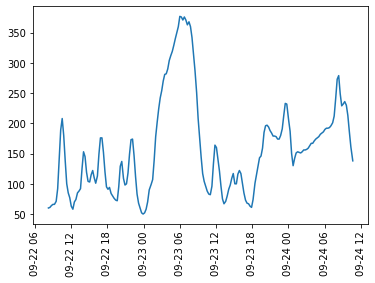

In [35]:
plt.figure()
start=np.random.randint(low=0, high=dfs.index.size)
N = 200
plt.plot(dfs.timestamp.values[start:start+N], dfs.aut_record.values[start:start+N])
plt.gcf().canvas.draw()

ax = plt.gca()
label = ax.get_xticklabels()
label = [l.get_text() for l in label]
ax.set_xticklabels(label, rotation=90)
plt.show()

## Sequence creation


In [0]:
one_day = np.timedelta64(1000000000*3600*24, 'ns')
one_hour = np.timedelta64(1000000000*3600, 'ns')
day_dict = {'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 
            'Friday': 4, 'Saturday': 5, 'Sunday': 6}

def get_time_data(data, idx, time_unit, zero_time=None):
    # get time feature, substract last time feature event, and normalize to time_unit
    
    # TODO we should already be working with datetimes
    ts = pd.to_datetime(data.timestamp.values[idx]) 
    hour = np.array([t.hour for t in ts])
    day = np.array([day_dict[t.day_name()] for t in ts])
    if not zero_time:
        zero_time = ts[-1]
    ts = np.array([(t-zero_time)/time_unit for t in ts])
    return hour, day, zero_time, ts

def get_sugar_data(data, idx, scaler=None):
    ys = data.aut_record.values[idx]
    if not scaler:
        min_ys = ys.min()
        max_ys = ys.max()
        scaler = (min_ys, max_ys)
    ys = (ys-scaler[0]) / (scaler[1] - scaler[0])
    return scaler, ys
    
def add_noise(y, noise=0.0):
    noisy_seq = np.random.normal(loc=0.0, scale=noise, size=y.size)
    y_noisy = y + noisy_seq
    return y_noisy
        
def create_sequence(data, start, history, future, feature_steps=1, label_steps=1, 
                    time_unit=one_day, noise=0.1, day_dict=day_dict):
    # get feature and label index ranges
    feature_range = np.arange(start=start, stop=start+history, step=feature_steps)
    label_range = np.arange(start=start+history, stop=start+history+future, step=label_steps)
    
    # get features
    scaler=(0.0, 1.0)  # to avoid scaling
    scaler = None
    hour_feature, day_feature, zero_time, ts_feature = get_time_data(data, feature_range, time_unit, 
                                                                     zero_time=None)
    scaler, ys_feature = get_sugar_data(data, feature_range, scaler=scaler)
    ys_feature_noisy = add_noise(ys_feature, noise) if noise > 0. else ys_feature
    id_feature = data.id.values[feature_range]
    # put together the id, sugar_level, hour, day and time_interval
    features = [ts_feature, hour_feature, day_feature, id_feature, ys_feature_noisy]
    comb_feature = np.stack(arrays=features, axis=1)
    
    # get labels
    hour_label, day_label, _, ts_label = get_time_data(data, label_range, time_unit, zero_time=zero_time)
    _, ys_label = get_sugar_data(data, label_range, scaler=scaler)
    id_label = data.id.values[label_range]
    labels = [ts_label,hour_label, day_label, id_label, ys_label]
    comb_label = np.stack(arrays=labels, axis=1)
    
    return ys_feature, comb_feature, comb_label        

def verify_sequence(feature, label, feature_steps, label_steps, min_v, max_v, 
                    hours_in_day=24.0, sampling=1.0):
    max_time_feature = feature_steps / sampling / 4.0 / hours_in_day
    max_time_label = label_steps / sampling / 4.0 / hours_in_day

    max_feature = -np.min(feature[:, 0]) / max_time_feature
    max_label = np.max(label[:, 0]) / max_time_label

    cond1 =  min_v <= max_feature <= max_v
    cond2 =  min_v <= max_label <= max_v

    return max_time_feature, max_time_label, max_feature, max_label, cond1, cond2

In [45]:
sampling

{0: 1, 1: 1, 2: 1, 3: 3, 4: 3, 5: 3, 6: 1, 7: 3, 8: 3}

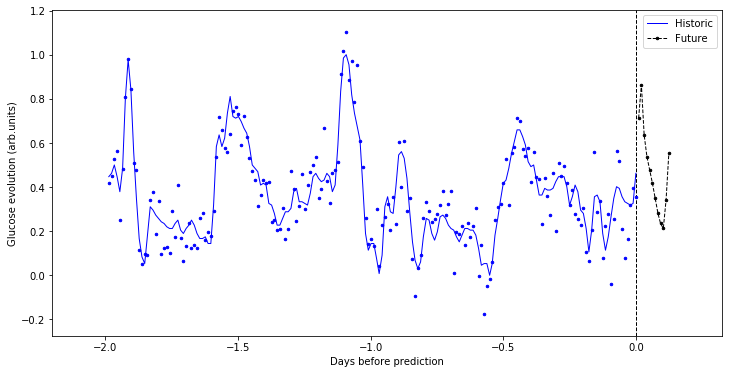

In [56]:
np.set_printoptions(threshold=np.inf)

start=np.random.randint(low=0, high=dfs.index.size)
id_ = dfs.iloc[start, :].id

# sampling: 1 corresponds to 15 minutes, 3 to 5 minutes
history_steps = sampling[id_] 
future_steps = sampling[id_]

# data is sampled every 5 or 15 minutes. Thus, there are 12 or 4 measurements per hour
history = 48 * 4 * history_steps # a history of 2 days
future = 3 * 4 * future_steps # this accounts for a prediction of 6 hours in advance

yf, ynf, yl = create_sequence(dfs, start=start, history=history, future=future, 
                              feature_steps=history_steps, label_steps=future_steps,
                              time_unit=one_day, noise=0.1, day_dict=day_dict)

# conditions for the length of the sequences
max_time_feature, max_time_label, max_feature, max_label, cond1, cond2 = \
  verify_sequence(ynf, yl, history, future, 0.8, 1.2, sampling=history_steps)

if not cond1 or not cond2:
    print(max_time_feature, max_time_label, max_feature, max_label, cond1, cond2)
    # print(dfs.values[start:start+history, :])

# plot sequences
plt.figure(figsize=(12, 6))

plt.plot(ynf[:, 0], yf, '-b', markersize=2, linewidth=1, label='Historic')
plt.plot(ynf[:, 0], ynf[:, -1], '.b', markersize=5, linewidth=1)
plt.plot(yl[:, 0], yl[:, -1], '.--k', markersize=5, linewidth=1, label='Future')

ymin = ynf[:, -1].min()-0.1
ymax = ynf[:, -1].max()+0.1

plt.vlines(x=0, ymin=ymin, ymax=ymax, colors='k', linewidth=1, linestyles='--')

plt.ylim(ymin, ymax)
plt.xlim(-history/4/24/history_steps-0.2, future/4/24/future_steps+0.2)

plt.ylabel('Glucose evolution (arb.units)')
plt.xlabel('Days before prediction')
plt.legend(loc='best')
plt.show()

### Check performance


In [57]:
%timeit yf, ynf, yl = create_sequence(dfs, 1046, 3*4*24, 3*4, 1, 1, one_day, 0.0, day_dict)

100 loops, best of 3: 10 ms per loop


In [58]:
%timeit yf, ynf, yl = create_sequence(dfs, 1046, 3*4*24, 3*4, 1, 1, one_day, 0.1, day_dict)

100 loops, best of 3: 9.95 ms per loop


In [59]:
%timeit yf, ynf, yl = create_sequence(dfs, 1046, 5*4*24, 3*4, 1, 1, one_day, 0.0, day_dict)

100 loops, best of 3: 15.5 ms per loop


## Split in train, vad and test


In [0]:
def add_sequences(starts, data, history, future, feature_steps, label_steps, replace,
                  noise, time_unit, day_dict, max_tol, min_tol):
    timesteps = history//feature_steps + future//label_steps
    out = np.zeros(shape=(starts.size, timesteps, 5), dtype=np.float32)
    k = 0
    for start in starts:
        _, ynf, yl = create_sequence(data, start=start, history=history, future=future, 
                                     feature_steps=feature_steps, label_steps=label_steps, 
                                     time_unit=time_unit, noise=noise, day_dict=day_dict)
        
        # conditions on maximum time
        max_time_feature, max_time_label, max_feature, max_label, cond1, cond2 = \
            verify_sequence(ynf, yl, history, future, min_tol, max_tol, sampling=feature_steps)

        if cond1 and cond2:
            out[k] = np.concatenate([ynf, yl], axis=0)
            k += 1
        else:
            out = np.delete(out, k, 0)
    return out

def parallelize_add_sequences(starts, **kwargs):
    n_cores= cpu_count()
    starts_split = np.array_split(starts, n_cores)
    pool = Pool(n_cores)
    partial_func = partial(add_sequences, **kwargs)
    out = np.concatenate(pool.map(partial_func, starts_split), axis=0)
    pool.close()
    pool.join()
    return out

def create_dataset(data, num_samples, min_idx, max_idx, history, future, 
                   feature_steps=1, label_steps=1, replace=False,
                   noise=0.1, time_unit=one_day, day_dict=day_dict, 
                   max_tol=1.2, min_tol=0.8,
                   seed=1098, verbose=False):
    # get all possible start indices
    indices = data.index[min_idx: max_idx-history-future+1]
    # generate num_samples starting indices
    np.random.seed(seed)
    starts = np.random.choice(indices, size=num_samples, replace=replace)
    
    inputs = dict(data=data, history=history, future=future, 
                  feature_steps=feature_steps, label_steps=label_steps, 
                  replace=replace, noise=noise, time_unit=time_unit, 
                  day_dict=day_dict, max_tol=max_tol, min_tol=min_tol)
    out= parallelize_add_sequences(starts, **inputs)
    
    if verbose:
        s = "We have added %s sequences (out of %s)." 
        print(s %(out.shape[0], num_samples))
    return out

In [62]:
hours = 3
for noise in [0.0]:
  for days in [3]:
    print('*'*60)
    print('*'*60)
    print('Noise %s, days %s' %(noise, days))
    print('*'*60)
    print('*'*60)

    seed = 17082
    max_tol = 1.2
    min_tol = 0.8
    train_samples_no_replace =  1.0
    train_samples_replace = 3
    replace = False if noise == 0.0 else True

    train, vad, test = [], [], []
    for id_ in dfs.id.unique():
        print('*'*60)
        print('Patient id=%s' %id_)
        print('*'*60)

        # filter data
        df_patient = dfs[dfs.id == id_].reset_index()
        df_patient.drop(columns=['index'], inplace=True)
        size = df_patient.shape[0]

        # sampling: 1 corresponds to 15 minutes, 3 to 5 minutes
        history_steps = sampling[id_] 
        future_steps = sampling[id_]
        # data is sampled every 5 or 15 minutes. Thus, there are 12 or 4 measurements per hour
        history = days * 24 * 4 * history_steps # a history of X days
        future = hours * 4 * future_steps # a history of X hours


        # train set size
        train_max_idx = int(size*0.8)
        if replace:
            num_samples_train = int(train_samples_replace * (train_max_idx-history-future))
        else:
            num_samples_train = int(train_samples_no_replace * (train_max_idx-history-future))

        # validation set size
        vad_max_id = int(size*0.9)
        num_samples_vad = vad_max_id - train_max_idx - history - future

        # testing set size
        num_samples_test = size - vad_max_id - history - future

        print("Creating train dataset; we will sample %s sequences." %num_samples_train)
        train_patient = create_dataset(df_patient, num_samples=num_samples_train, min_idx=0, max_idx=train_max_idx, 
                                      history=history, future=future, feature_steps=history_steps, label_steps=future_steps,
                                      replace=replace, noise=noise, time_unit=one_day, 
                                      max_tol=max_tol, min_tol=min_tol, seed=seed, verbose=True)

        print("Creating validation dataset; we will sample %s sequences." %num_samples_vad)
        vad_patient = create_dataset(df_patient, num_samples=num_samples_vad, min_idx=train_max_idx, max_idx=vad_max_id, 
                                    history=history, future=future, feature_steps=history_steps, label_steps=future_steps,
                                    replace=False, noise=0.0, time_unit=one_day, 
                                    max_tol=max_tol, min_tol=min_tol, seed=seed, verbose=True)

        print("Creating test dataset; we will sample %s sequences." %num_samples_test)
        test_patient = create_dataset(df_patient, num_samples=num_samples_test, min_idx=vad_max_id, max_idx=size, 
                                      history=history, future=future, feature_steps=history_steps, label_steps=future_steps,
                                      replace=False, noise=0.0, time_unit=one_day, 
                                      max_tol=max_tol, min_tol=min_tol, seed=seed, verbose=True)

        msg = 'For patient id={id_}, the size of the train, vad and test sets is ({train}, {vad}, {test}), respectively.'
        msg = msg.format(id_=id_, train=train_patient.shape[0], vad=vad_patient.shape[0], test=test_patient.shape[0])
        print(msg)

        train.append(train_patient)
        vad.append(vad_patient)
        test.append(test_patient)

    train = np.concatenate(train, axis=0)
    vad = np.concatenate(vad, axis=0)
    test = np.concatenate(test, axis=0)

    msg = 'The final size of the train, vad and test sets is ({train}, {vad}, {test}), respectively.'
    msg = msg.format(train=train.shape[0], vad=vad.shape[0], test=test.shape[0])
    print(msg)

    print('Saving')
    np.save(os.path.join(outdir, "noise_%s_train_steps_%s_replace_%s.npy" %(noise, int(history), replace)), train)
    np.save(os.path.join(outdir, "noise_%s_vad_steps_%s_replace_%s.npy" %(noise, int(history), replace)), vad)
    np.save(os.path.join(outdir, "noise_%s_test_steps_%s_replace_%s.npy" %(noise, int(history), replace)), test)

************************************************************
************************************************************
Noise 0.0, days 3
************************************************************
************************************************************
************************************************************
Patient id=4
************************************************************
Creating train dataset; we will sample 14938 sequences.
We have added 13520 sequences (out of 14938).
Creating validation dataset; we will sample 1080 sequences.
We have added 1044 sequences (out of 1080).
Creating test dataset; we will sample 1080 sequences.
We have added 1044 sequences (out of 1080).
For patient id=4, the size of the train, vad and test sets is (13520, 1044, 1044), respectively.
************************************************************
Patient id=3
************************************************************
Creating train dataset; we will sample 84398 sequences.
We have add

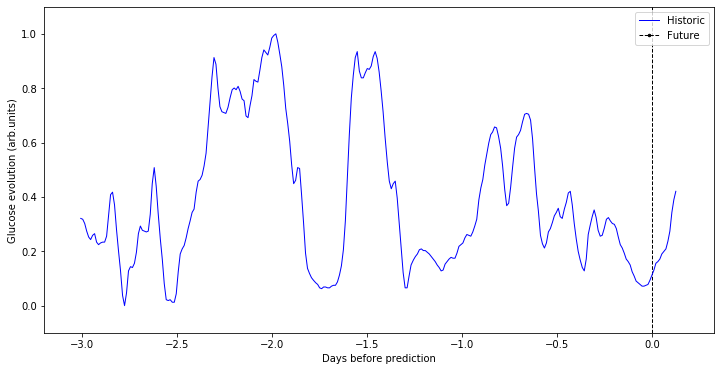

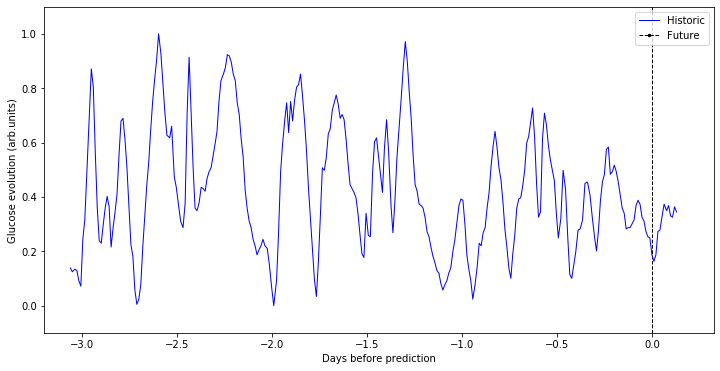

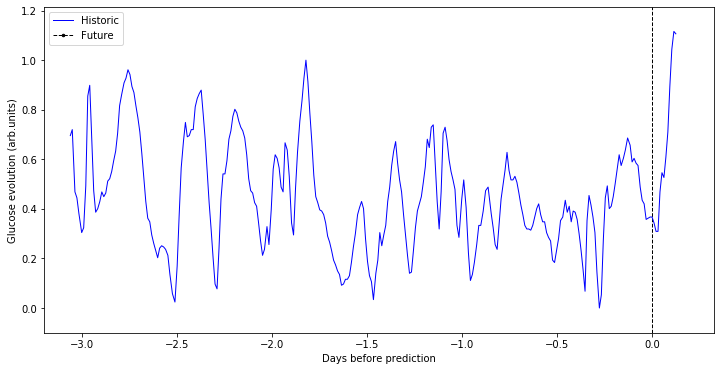

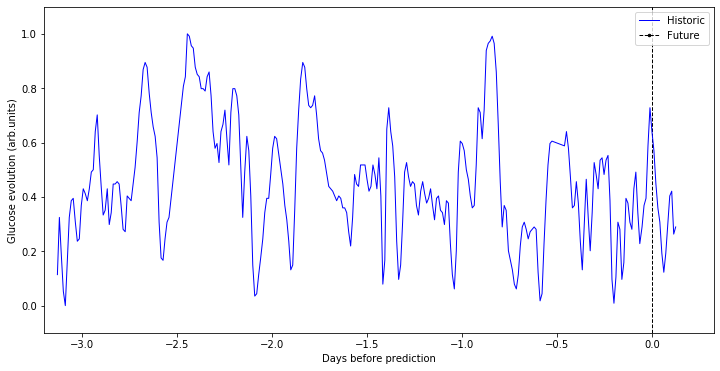

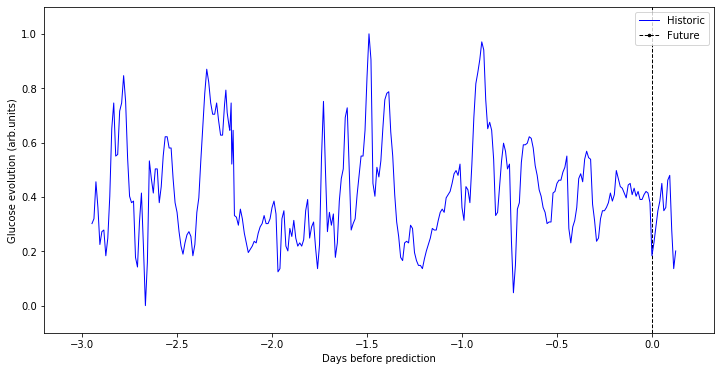

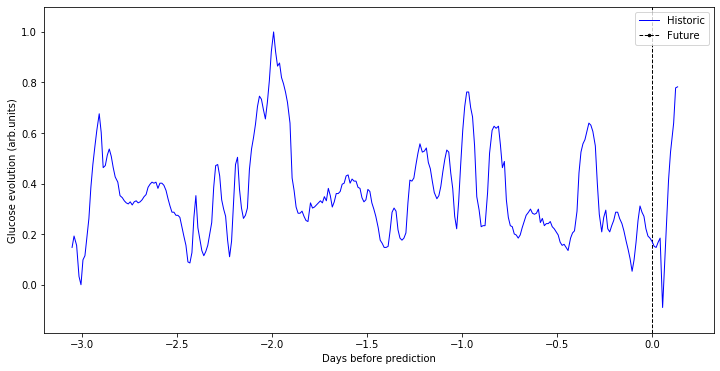

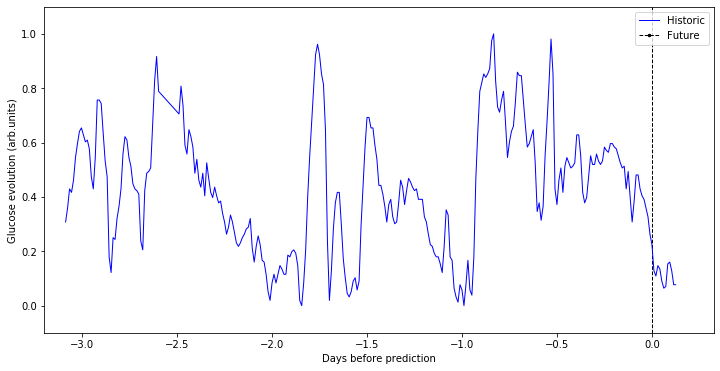

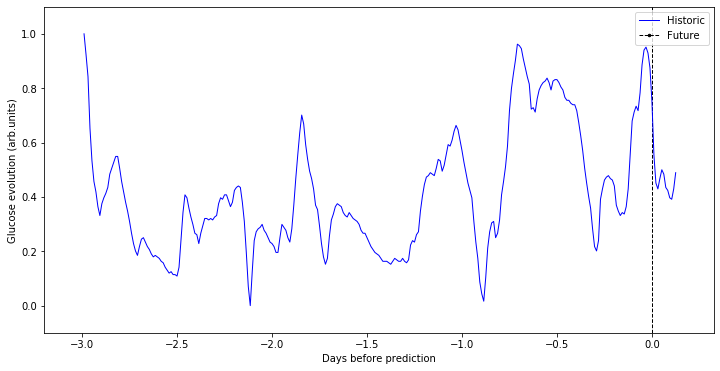

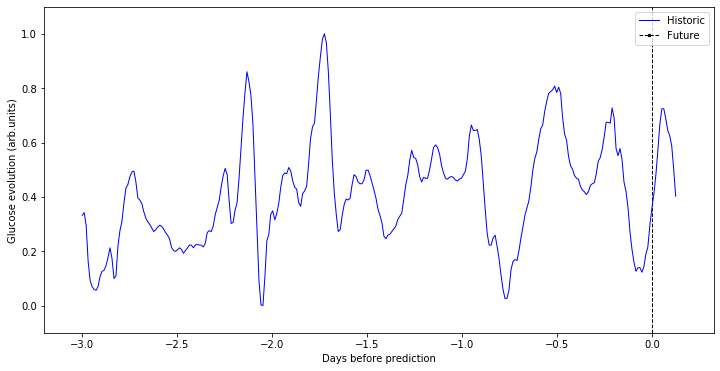

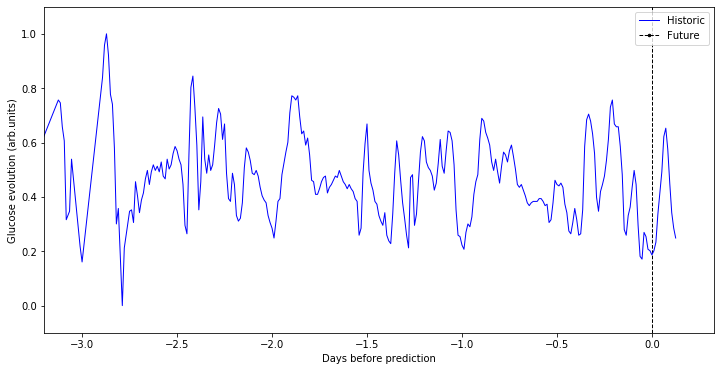

In [64]:
for _ in np.arange(10):

  plt.figure(figsize=(12, 6))

  idx=np.random.randint(low=0, high=vad.shape[0])
  xf, xl = vad[idx, :history, 0], vad[idx, history:history+future, 0]
  yf, yl = vad[idx, :history, -1], vad[idx, history:history+future, -1]
  
  ymin = yf.min()-0.1
  ymax = yf.max()+0.1

  plt.plot(xf, yf, '-b', markersize=2, linewidth=1, label='Historic')
  plt.plot(xl, yl, '.--k', markersize=5, linewidth=1, label='Future')
  plt.vlines(x=0, ymin=ymin, ymax=ymax, colors='k', linewidth=1, linestyles='--')

  plt.ylim(ymin, ymax)
  plt.xlim(-history/4/24/history_steps-0.2, future/4/24/future_steps+0.2)
  
  plt.ylabel('Glucose evolution (arb.units)')
  plt.xlabel('Days before prediction')
  plt.legend(loc='best')
  plt.show()